# tsam - 1. Example
Example usage of the time series aggregation module (tsam) using wind data clustered by k-shape method.
Date: 13.02.2017

Author: Maximilian Hoffmann

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
%matplotlib inline

### Input data

Read in time series from testdata.csv with pandas

In [2]:
raw_complete = pd.read_csv('testdata.csv', index_col = 0)

Show a slice of the dataset

In [3]:
raw_complete.head()

,GHI,T,Wind,Load
2009-12-31 23:30:00,0,-2.1,7.1,375.478394
2010-01-01 00:30:00,0,-2.8,8.6,364.541326
2010-01-01 01:30:00,0,-3.3,9.7,357.416844
2010-01-01 02:30:00,0,-3.2,9.8,350.191306
2010-01-01 03:30:00,0,-3.2,9.4,345.161449


Show the shape of the raw_complete input data: 4 types of timeseries (GHI, Temperature, Wind and Load) for every hour in a year

In [4]:
raw_complete.shape

(8760, 4)

Cut wind column out and save it as a new pandas data frame

In [5]:
raw=raw_complete.loc[:,'Wind'].to_frame()

Show a slice of the new data set

In [6]:
raw.head()

,Wind
2009-12-31 23:30:00,7.1
2010-01-01 00:30:00,8.6
2010-01-01 01:30:00,9.7
2010-01-01 02:30:00,9.8
2010-01-01 03:30:00,9.4


Show the shape of the raw input data: One type of timeseries (Wind) for every hour in a year

In [7]:
raw.shape

(8760, 1)

Create a plot function for the wind for a visual comparison of the time series

In [8]:
def plotTS(data, periodlength, vmin, vmax):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label('Wind [m/s]')

Plot an example series - in this case the wind

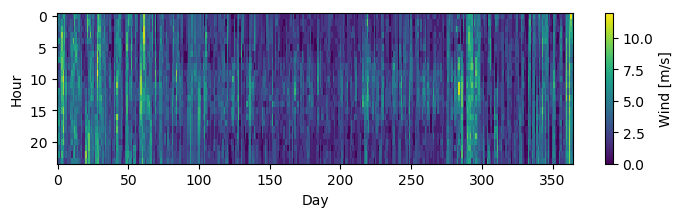

In [9]:
plotTS(raw['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

### Simple k-means aggregation

Initialize an aggregation class object with k-means as method for eight typical days, without any integration of extreme periods. Alternative clustering methods (clusterMethod) are 'averaging', 'k_medoids', 'hierarchical' and 'k_shape'.

In [10]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'k_means')

Create the typical periods

In [11]:
typPeriods = aggregation.createTypicalPeriods()

Show shape of typical periods: 1 type of timeseries for 24x24 hours

In [12]:
typPeriods.shape

(192, 1)

Save typical periods to .csv file

In [13]:
typPeriods.to_csv('testperiodsshape.csv')

Repredict the original time series based on the typical periods

In [14]:
predictedPeriodsKmeans = aggregation.predictOriginalData()

Plot the repredicted data

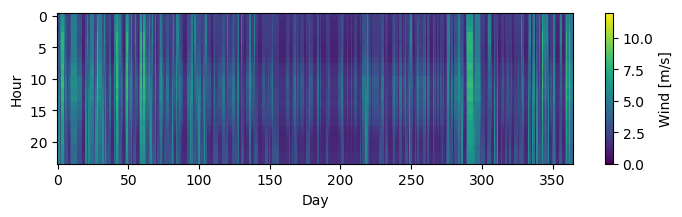

In [15]:
plotTS(predictedPeriodsKmeans['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

As seen, the days with wind peaks in the morning or in the evening are mostly neglected while those at noon (most significant ones) are taken into account. To overcome this issue, the k-shape algorithm is used which allows to take temporal shifting into account while clustering.

### K-shape aggregation

Initialize an aggregation class object with k-shape as method for eight typical days, without any integration of extreme periods. Alternative clustering methods (clusterMethod) are 'averaging', 'k_medoids', 'hierarchical' and 'k_shape'.

In [16]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'k_shape')

Create the typical periods

In [17]:
typPeriods = aggregation.createTypicalPeriods()

The aggregation can also be evaluated by indicators

In [18]:
aggregation.accuracyIndicators()

,RMSE,RMSE_duration,MAE
Wind,0.168457,0.063364,0.130561


Repredict the original time series based on the typical periods

In [19]:
predictedPeriodsKshape = aggregation.predictOriginalData()

Plot repredicted data

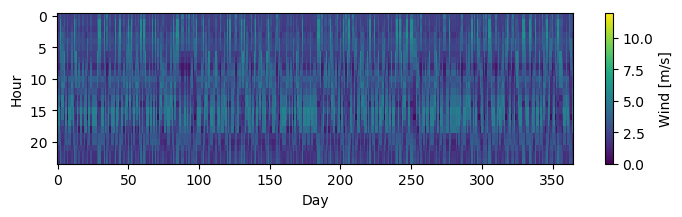

In [20]:
plotTS(predictedPeriodsKshape['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

As it can be seen, days with demand peaks during the morning or the evening are now taken into account as well. However, the representation of extreme values is very poor.

### Comparison of the aggregations 

In order to estimate the error due to the to clustering alogrithms, which do not explicitly take extreme periods into account, the wind duration curves of the original wind data as well as the clustered and replicated ones are plotted.

Text(0, 0.5, 'Wind Duration Curve [m/s]')

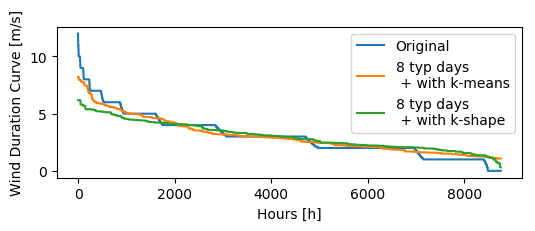

In [21]:
fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
raw['Wind'].sort_values(ascending=False).reset_index(drop=True).plot(label = 'Original')
predictedPeriodsKmeans['Wind'].sort_values(ascending=False).reset_index(drop=True).plot(label = '8 typ days \n + with k-means')
predictedPeriodsKshape['Wind'].sort_values(
    ascending=False).reset_index(drop=True).plot(label = '8 typ days \n + with k-shape')
plt.legend()
plt.xlabel('Hours [h]')
plt.ylabel('Wind Duration Curve [m/s]')

The comparison of the duration curves shows that both algorithms do not manage to replicate extreme periods appropriately. Yet, the k-means algorithm provides better results for the peak values, while the k-shape algorithm provides better trough values.
The replicated time series can also be illustrated for an expemplary week:

Text(0, 0.5, 'Wind Duration Curve [m/s]')

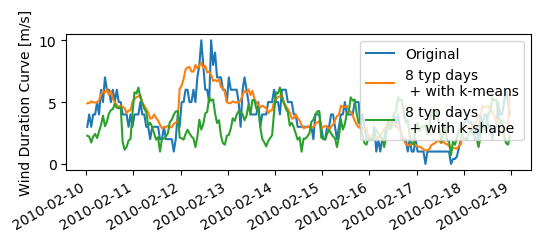

In [22]:
fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
raw['Wind']['20100210':'20100218'].plot(label = 'Original')
predictedPeriodsKmeans['Wind']['20100210':'20100218'].plot(label = '8 typ days \n + with k-means')
predictedPeriodsKshape['Wind']['20100210':'20100218'].plot(label = '8 typ days \n + with k-shape')
plt.legend()
plt.ylabel('Wind Duration Curve [m/s]')

Once again it can be seen that k-means better meet the peak values. However, there is a clear temporal offset between the k-means peaks and the real wind peaks. In contrast to that, k-shape has its peaks at the right places, but not the right total values for representing them properly.

### Showing the right rescaling of the total data

In [23]:
raw['Wind'].sum()

26782.0

In [24]:
predictedPeriodsKmeans['Wind'].sum()

26782.0

In [25]:
predictedPeriodsKshape['Wind'].sum()

26781.999999999993